# Library

In [1]:
! git clone https://github.com/NVIDIA/apex
! cd apex
! pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" /kaggle/working/apex/

Cloning into 'apex'...
remote: Enumerating objects: 8102, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 8102 (delta 92), reused 123 (delta 63), pack-reused 7913
Receiving objects: 100% (8102/8102), 14.15 MiB | 10.52 MiB/s, done.
Resolving deltas: 100% (5493/5493), done.
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7

In [2]:
pip install simpletransformers

     |████████████████████████████████| 221 kB 7.8 MB/s 
     |████████████████████████████████| 2.6 MB 13.7 MB/s 
     |████████████████████████████████| 1.2 MB 63.0 MB/s 
     |████████████████████████████████| 3.3 MB 69.8 MB/s 
     |████████████████████████████████| 124 kB 70.4 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 1.7 MB 45.5 MB/s 
     |████████████████████████████████| 76 kB 4.5 MB/s 
     |████████████████████████████████| 7.9 MB 70.2 MB/s 
     |████████████████████████████████| 264 kB 66.6 MB/s 
     |████████████████████████████████| 895 kB 64.2 MB/s 
     |████████████████████████████████| 636 kB 54.1 MB/s 
     |████████████████████████████████| 170 kB 86.4 MB/s 
     |████████████████████████████████| 188 kB 71.7 MB/s 
     |████████████████████████████████| 133 kB 85.8 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 243 kB 91.9 MB/s 
     |███████████████

In [3]:
pip install pyvi

     |████████████████████████████████| 8.5 MB 6.5 MB/s 
     |████████████████████████████████| 743 kB 75.7 MB/s 


In [4]:
# pip install transformers==4.3.0

# Data loader

In [3]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from pyvi.ViTokenizer import ViTokenizer
import re

In [4]:
# load data
train = pd.read_csv("drive/MyDrive/CODE/ViSocial/dataset/ctsd/aug/train_augmented_dataset.csv", index_col=False)
dev = pd.read_csv("drive/MyDrive/CODE/ViSocial/dataset/ctsd/UIT-ViCTSD_valid.csv", index_col=False)
test = pd.read_csv("drive/MyDrive/CODE/ViSocial/dataset/ctsd/UIT-ViCTSD_test_label.csv", index_col=False)

train.reset_index(drop=True)

print(len(train))
print(len(dev))
print(len(test))

11048
2000
1000


In [5]:
#pre-process

STOPWORDS = 'drive/My Drive/CODE/ViSocial/vietnamese-stopwords-dash.txt'
with open(STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
        
    return train_sentences

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess(text, tokenized=True, lowercased=True):
    text = text.lower() if lowercased else text
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    return text

def pre_process_features(X, y, tokenized=True, lowercased=True):
    X = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

X_train = train['Comment']
y_train = train['Toxicity'].values

X_dev = dev['Comment']
y_dev = dev['Toxicity'].values

X_test = test['Comment']
y_test = test['Toxicity'].values

# Model

## Bert multilingual CASED

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/11048 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/691 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/691 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/691 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

[[847  43]
 [ 75  35]]
F1 - micro: 0.882
F1 - macro: 0.6536095063641915
Accuracy: 0.882


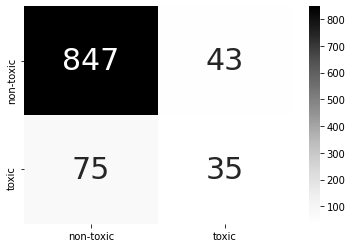

In [8]:
#BERT-multilingual-cased
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = False)

train = pd.DataFrame({'text': train_X, 'labels': train_y})
dev = pd.DataFrame({'text': dev_X, 'labels': dev_y})
test = pd.DataFrame({'text': test_X, 'labels': test_y})

model_args = ClassificationArgs()
model_args.output_dir = "drive/My Drive/CODE/ViSocial/transformer_model_aug/victsd-toxic/mbert-cased-v1/"
model_args.reprocess_input_data = True
model_args.overwrite_output_dir = True
model_args.evaluate_during_training = False
model_args.manual_seed = 4
model_args.use_multiprocessing = True
model_args.train_batch_size = 16
model_args.eval_batch_size = 16
model_args.labels_list = [0, 1]
model_args.max_seq_length = 100
model_args.num_train_epochs = 4

model = ClassificationModel('bert', 'bert-base-multilingual-cased', num_labels=2, args=model_args)

model.train_model(train, validation_data=dev)

result, model_outputs, wrong_predictions = model.eval_model(test)

label_true_test = test.labels.values
label_pred_test = model_outputs.argmax(axis=-1)

y_pred = label_pred_test.tolist()
y_true = label_true_test.tolist()

cf1 = confusion_matrix(y_true, y_pred)
print(cf1)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(y_true, y_pred)
print("Accuracy: " + str(evaluation))

# Uncomment if you want to print out the result to .csv

# test_data['predict_label_id'] = y_pred
# test_data.to_csv('drive/My Drive/CODE/HSD/test_predicted.csv', index=False)

# Show out the confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["non-toxic","toxic"],
                  columns = ["non-toxic","toxic"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

## bert multilingual UNCASED

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

  0%|          | 0/11048 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/691 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/691 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/691 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

[[741 149]
 [ 74  36]]
F1 - micro: 0.777
F1 - macro: 0.5566380038769322
Accuracy: 0.777


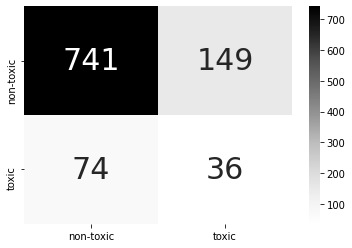

In [9]:
#BERT-multilingual-uncased
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = True)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = True)

train = pd.DataFrame({'text': train_X, 'labels': train_y})
dev = pd.DataFrame({'text': dev_X, 'labels': dev_y})
test = pd.DataFrame({'text': test_X, 'labels': test_y})

model_args = ClassificationArgs()
model_args.output_dir = "drive/My Drive/CODE/ViSocial/transformer_model_aug/victsd-toxic/mbert-uncased-v1/"
model_args.reprocess_input_data = True
model_args.overwrite_output_dir = True
model_args.evaluate_during_training = False
model_args.manual_seed = 4
model_args.use_multiprocessing = True
model_args.train_batch_size = 16
model_args.eval_batch_size = 16
model_args.labels_list = [0, 1]
model_args.max_seq_length = 100
model_args.num_train_epochs = 4

model = ClassificationModel('bert', 'bert-base-multilingual-uncased', num_labels=2, args=model_args)

model.train_model(train, validation_data=dev)

result, model_outputs, wrong_predictions = model.eval_model(test)

label_true_test = test.labels.values
label_pred_test = model_outputs.argmax(axis=-1)

y_pred = label_pred_test.tolist()
y_true = label_true_test.tolist()

cf2 = confusion_matrix(y_true, y_pred)
print(cf2)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(y_true, y_pred)
print("Accuracy: " + str(evaluation))

# test_data['predict_label_id'] = y_pred
# test_data.to_csv('drive/My Drive/CODE/HSD/test_predicted.csv', index=False)

df_cm2 = pd.DataFrame(cf2, index = ["non-toxic","toxic"],
                  columns = ["non-toxic","toxic"])
plt.clf()
sn.heatmap(df_cm2, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

## XLM-R

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:490: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  f"use_multiprocessing automatically disabled as {model_type}"


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/691 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/691 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/691 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/691 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[[890   0]
 [110   0]]
F1 - micro: 0.89
F1 - macro: 0.4708994708994709
Accuracy: 0.89


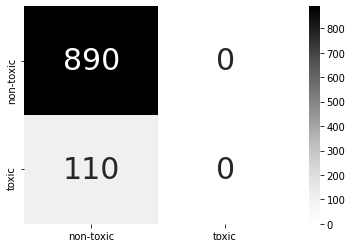

In [10]:
#XLM-R

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = False)

train = pd.DataFrame({'text': train_X, 'labels': train_y})
dev = pd.DataFrame({'text': dev_X, 'labels': dev_y})
test = pd.DataFrame({'text': test_X, 'labels': test_y})

model_args = ClassificationArgs()
model_args.output_dir = "drive/My Drive/CODE/ViSocial/transformer_model_aug/victsd-toxic/xlm-r-v1/"
model_args.reprocess_input_data = True
model_args.overwrite_output_dir = True
model_args.evaluate_during_training = False
model_args.manual_seed = 4
model_args.use_multiprocessing = True
model_args.train_batch_size = 16
model_args.eval_batch_size = 16
model_args.labels_list = [0, 1]
model_args.max_seq_length = 100
model_args.num_train_epochs = 4

model = ClassificationModel('xlmroberta', 'xlm-roberta-base', num_labels=2, args=model_args)

model.train_model(train, validation_data=dev)

result, model_outputs, wrong_predictions = model.eval_model(test)

label_true_test = test.labels.values
label_pred_test = model_outputs.argmax(axis=-1)

y_pred = label_pred_test.tolist()
y_true = label_true_test.tolist()

cf3 = confusion_matrix(y_true, y_pred)
print(cf3)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(y_true, y_pred)
print("Accuracy: " + str(evaluation))

# test_data['predict_label_id'] = y_pred
# test_data.to_csv('drive/My Drive/CODE/HSD/test_predicted.csv', index=False)

df_cm3 = pd.DataFrame(cf3, index = ["non-toxic","toxic"],
                  columns = ["non-toxic","toxic"])
plt.clf()
sn.heatmap(df_cm3, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

## DistilBERT

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.bias', 'classifie

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/11048 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/691 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/691 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/691 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/691 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

[[824  66]
 [ 74  36]]
F1 - micro: 0.8599999999999999
F1 - macro: 0.6306614326115403
Accuracy: 0.86


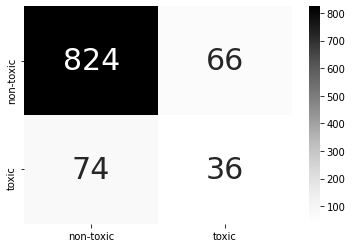

In [11]:
#DistilBERT

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = False)

train = pd.DataFrame({'text': train_X, 'labels': train_y})
dev = pd.DataFrame({'text': dev_X, 'labels': dev_y})
test = pd.DataFrame({'text': test_X, 'labels': test_y})

model_args = ClassificationArgs()
model_args.output_dir = "drive/My Drive/CODE/ViSocial/transformer_model_aug/victsd-toxic/distilbert-v1/"
model_args.reprocess_input_data = True
model_args.overwrite_output_dir = True
model_args.evaluate_during_training = False
model_args.manual_seed = 4
model_args.use_multiprocessing = True
model_args.train_batch_size = 16
model_args.eval_batch_size = 16
model_args.labels_list = [0, 1]
model_args.max_seq_length = 100
model_args.num_train_epochs = 4

model = ClassificationModel('distilbert', 'distilbert-base-multilingual-cased', num_labels=2, args=model_args)

model.train_model(train, validation_data=dev)

result, model_outputs, wrong_predictions = model.eval_model(test)

label_true_test = test.labels.values
label_pred_test = model_outputs.argmax(axis=-1)

y_pred = label_pred_test.tolist()
y_true = label_true_test.tolist()

cf4 = confusion_matrix(y_true, y_pred)
print(cf4)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(y_true, y_pred)
print("Accuracy: " + str(evaluation))

# test_data['predict_label_id'] = y_pred
# test_data.to_csv('drive/My Drive/CODE/HSD/test_predicted.csv', index=False)

df_cm4 = pd.DataFrame(cf4, index = ["non-toxic","toxic"],
                  columns = ["non-toxic","toxic"])
plt.clf()
sn.heatmap(df_cm4, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})